# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import time
import progressbar as pb
from custom_modules.helper_functions import *

# Assisting Functions

In [2]:
def load_mfdata(country_groups, options_code):
    """
    Load mutual fund returns data.
    
    Parameters
    ----------
    country_groups : sequence of str
        Country group codes to append to filenames for reading
    options_code : str
        A code that indicates from which folder to load the data. This
        string encodes options parameters that were selected during the
        refinement of the mutual fund data.
    
    Returns
    -------
    df_return : DataFrame
        The loaded and formatted data to be read.
    
    """
    
    # Declare the start and end of the filenames to be loaded.
    f_base = (
        "..\\Data\\Refined Data\\Mutual Funds\\{}\\mf_".format(options_code)
    )
    f_end = ".csv"

    # Concatenate all country group DataFrames together in the selected
    # folder.
    df_return = pd.concat([pd.read_csv(f_base+country_code+f_end,
                                       parse_dates=["date"])
                           for country_code in country_groups],
                          ignore_index=True)
                                                                                  
    return df_return

In [3]:
def beta_hists(df_betas):
    """
    Display histograms of all factor beta distributions for a given
    table of beta values.
    
    Parameters
    ----------
    df_betas : DataFrame
        The table of beta values to be plotted.
    """
    
    for i in df_betas.columns[:6]:
        print(i)
        plt.hist(df_betas[i], bins=100,
                 range=df_betas[i].quantile([0.001, 0.999]))
        plt.show()

# Load Data

In [4]:
# Define country group strings and options code
country_groups = ["lux", "kor", "usa", "can-chn-jpn", "irl-bra", "gbr-fra-ind",
                  "esp-tha-aus-zaf-mex-aut-che", "other"]

options_code = "eq-strict"

In [5]:
# TODO: Eliminate missing gross returns?
# Mutual Fund data
df_mf = load_mfdata(country_groups, options_code)

In [71]:
# Currency factor data
df_crfactors = pd.read_csv("..\\Data\\Refined Data\\Currencies\\curr_factors.csv",
                          parse_dates=[0])

In [72]:
# World equity factor data
df_eqfactors = pd.read_csv("..\\Data\\Refined Data\\Equity Factors\\ff4.csv",
                          parse_dates=[0])

In [73]:
# Combine both sets of factor returns into several complete factor
# DataFrames.
df_factors_lrv11 = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "hml_fx", "rx"]],
                       on="date", how="left")
)

df_factors_lrv11net = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "hml_fx_net", "rx_net"]],
                       on="date", how="left")
)

df_factors_v18 = (
    df_eqfactors.merge(df_crfactors.loc[:,["date", "carry", "dollar"]],
                       on="date", how="left")
)

# Prepare mutual funds data

In [ ]:
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- ><-11chars->
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- >< ---18 chars--- >
def mf_prep(df_mf_in, df_rf, return_column="ret_gross_m"):
    """
    Subtract the risk-free rate from the mutual fund returns and isolate
    the requested returns column.
        
    Parameters
    ----------
    df_mf_in : DataFrame
        A DataFrame with dates and mutual funds returns in the columns.
    df_rf : DataFrame
        A DataFrame containing dates and risk-free rates on those dates.
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    
    Returns
    -------
    df_out : DataFrame
        Transformed mutual fund returns.
    """ 
    
    # Combine the data.
    df_mf = df_mf_in.merge(df_rf, on="date")
    
    # Subtract the risk-free rate
    df_mf["ret"] = df_mf[return_column]-df_mf.rf
    
    # Pivot to wide-form
    
    return df_mf.loc[:, ["date", "ret", ""]]

# Beta Regressions

In [23]:
def get_betas(df_fund, fundid, df_factors, min_obs=24, betas_only=False):
    """
    Calculate the coefficients of a regression of a single mutual fund's
    returns on factor returns.
        
    Parameters
    ----------
    df_fund : DataFrame
        A DataFrame with dates in the index and mutual funds returns in
        the columns.
    fundid : str
        The fundid of the mutual fund for which betas should be
        calculated.
    df_factors : DataFrame
        A DataFrame containing dates and a set of factor returns on
        those dates, where each column gives returns of a different
        factor
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    min_obs : int, default 24
        The minimum number of nonmissing observations of returns
        required for a beta value to be calculated.
    betas_only : bool, default False
        If True, only the beta parameters will be returned. If false,
        additional regression information will be returned alongside
        the betas.
    
    Returns
    -------
    betas_out : sequence of float
        An array containing the regression betas.
    
    """       
    # Combine the exogenous and endogenous time-series into one matrix
    # so that rows where any variable is missing can be dropped.
    dmatrix = (
        pd.concat([df_fund.loc[:, fundid], df_factors], axis=1)
          .dropna(how="any")
    )
    
    # If there are not enough overlapping non-missing observations,
    # return a null result.
    if dmatrix.index.size < min_obs:
        return np.array([])
    
    exog = dmatrix[fundid]
    endog = sm.add_constant(dmatrix.loc[:, df_factors.columns])
    
    # Perform OLS regression and return the betas
    ols_results = sm.OLS(exog, endog).fit()
    
    betas_out = ols_results.params.values[1:]
    if not betas_only:
        # Trying to take the r-squared of a series with constant
        # exogenous variable results in a warning. Avoid this by setting
        # r-squared to nan in this case.
        if exog.std() == 0:
            r_squared = np.nan
        else:
            r_squared = ols_results.rsquared
            
        betas_out = np.concatenate([betas_out, [r_squared,
                                   dmatrix.index.size]])
    return betas_out

In [77]:
def beta_table(df_mf_in, df_factors_in, return_column="ret_gross_m", min_obs=24,
               betas_only=False, loadingbar=False, load=True, save=True,
               save_folder=options_code):
    """
    Build a table of the time-series regression coefficients of mutual
    fund returns on factor returns.
        
    Parameters
    ----------
    df_mf_in : DataFrame
        A DataFrame containing dates and mutual funds' returns on those
        dates.
    df_factors_in : DataFrame
        A DataFrame containing dates and a set of factor returns on
        those dates, where each column gives returns of a different
        factor
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    min_obs : int, default 24
        The minimum number of nonmissing observations of returns
        required for a beta value to be calculated.
    betas_only : bool, default False
        If True, only the beta parameters will be returned. If false,
        additional regression information will be returned alongside
        the betas.
    loadingbar : bool, default False
        If True, a loadingbar is shown run the function is being run.
    load : bool, default True
        If True, a load of the results are attempted before running the
        function.
    save : bool, default True
        If True, the results are saved to file.
    save_folder : str, default $options_code
        The folder in which to save and attempt loads of regression
        results

    
    Returns
    -------
    df_out : DataFrame
        A DataFrame of the regression betas along with additional
        regression information if desired.
    """
    if save or load:
        # Set the save directory
        save_dir = "..\\Data\\Regression Results\\{}".format(save_folder)
        
        # Check the column names of the input factors DataFrame to
        # determine the filename of potential saves
        if "hml_fx" in df_factors_in:
            filename = "lrv11_betas"
        elif "hml_fx_net" in df_factors_in:
            filename = "lrv11net_betas"
        elif "carry" in df_factors_in:
            filename = "v18_betas"
        else:
            raise ValueError("This factors DataFrame is not recognised.")
            
    if load:
        try:
            if betas_only:
                df_out = pd.read_csv("{save_dir}\\{filename}.csv"
                                     .format(save_dir=save_dir,
                                             filename=filename))
            else:
                df_out = pd.read_csv("{save_dir}\\{filename}.csv"
                                     .format(save_dir=save_dir,
                                             filename=filename+"_plus"))
            
            print("Results loaded from file.")
            
            return df_out
        except FileNotFoundError:
            pass
        
    # Intialise empty dictionary to hold regression results and to be
    # transformed later into a DataFrame.
    dict_betas = dict()
    
    # Subtract the risk-free rate from mutual fund returns
    df_mf = df_mf_in.merge(df_factors_in[["date", "rf"]], on="date")
    df_mf["ret"] = df_mf[return_column]-df_mf.rf
    
    # Transform the mutual funds DataFrame to wide form to work with the
    # beta function.
    df_mf = df_mf.pivot(index="date", columns="fundid",
                        values="ret_gross_m")
    
    
    # Set the index of the factors DataFrame if necessary
    df_factors = df_factors_in.copy()
    
    if "date" in df_factors.columns:
        df_factors.set_index("date", inplace=True)
    
    
    # Loop through all mutual funds in the DataFrame and call the
    # time-series regression
    if loadingbar:
        bar = pb.ProgressBar(max_value=df_mf.columns.size)
        bar.update(0)
        
    for i in df_mf.columns: 
        asset_beta = get_betas(df_mf, i, df_factors, return_column, min_obs,
                               betas_only)

        # Only add the betas to the return dictionary if they exist
        if asset_beta.size > 0:
            dict_betas[i] = asset_beta        
        if loadingbar:
            if bar.value == bar.max_value-1:
                # The loading bars stopped updating just before 100%, so
                # this forces them to catch up.
                time.sleep(0.1)
            bar.update(bar.value+1)
    
    # Determine output DataFrame columns
    return_columns = list(df_factors.columns+"_beta")

    if not betas_only:
        return_columns = return_columns + ["r2", "n_obs"]

    # Return a new dataframe of beta values for each fund
    df_out = pd.DataFrame.from_dict(dict_betas, orient="index",
                                    columns=return_columns)
    df_out.columns.name = None
    
    if save:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if betas_only:
            df_out.to_csv("{save_dir}\\{filename}.csv"
                          .format(save_dir=save_dir, filename=filename))
        else:
            df_out.to_csv("{save_dir}\\{filename}.csv"
                          .format(save_dir=save_dir,
                                  filename=filename+"_plus"))
            
            
            df_out.drop(["r2", "n_obs"],
                        axis=1).to_csv("{save_dir}\\{filename}.csv"
                                       .format(save_dir=save_dir,
                                               filename=filename))
        
    return df_out

In [78]:
df_betas_lrv11 = beta_table(df_mf, df_factors_lrv11, load=False, loadingbar=True)

100% (61245 of 61245) |##################| Elapsed Time: 0:04:05 ETA:  00:00:00

In [79]:
df_betas_lrv11net = beta_table(df_mf, df_factors_lrv11net, load=False, loadingbar=True)

100% (61245 of 61245) |##################| Elapsed Time: 0:04:00 ETA:  00:00:00

In [80]:
df_betas_v18 = beta_table(df_mf, df_factors_v18, load=False, loadingbar=True)

100% (61245 of 61245) |##################| Elapsed Time: 0:04:02 ETA:  00:00:00

# Return Decomposition

In [ ]:
def ret_decomp(df_mf_in, df_betas_in, return_column="ret_gross_m",
               min_obs=24, loadingbar=False, load=True, save=True,
               save_folder=options_code):
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- ><-11chars->
#< ----20 chars---- >< ----20 chars---- >< ----20 chars---- >< ---18 chars--- >
    """
    Build a table of decomposed returns from mutual fund returns,
    mutual fund betas and factor returns.
        
    Parameters
    ----------
    df_mf_in : DataFrame
        A DataFrame containing dates and mutual funds' returns on those
        dates.
    df_factors_in : DataFrame
        A DataFrame containing dates and a set of factor returns on
        those dates, where each column gives returns of a different
        factor
    return_column : str, default 'ret_gross_m'
        The column in the fund DataFrame that gives returns.
    min_obs : int, default 24
        The minimum number of nonmissing observations of returns
        required for a beta value to be calculated.
    betas_only : bool, default False
        If True, only the beta parameters will be returned. If false,
        additional regression information will be returned alongside
        the betas.
    loadingbar : bool, default False
        If True, a loadingbar is shown run the function is being run.
    load : bool, default True
        If True, a load of the results are attempted before running the
        function.
    save : bool, default True
        If True, the results are saved to file.
    save_folder : str, default $options_code
        The folder in which to save and attempt loads of regression
        results

    
    Returns
    -------
    df_out : DataFrame
        A DataFrame of the regression betas along with additional
        regression information if desired.
    """

In [58]:
df_betas_lrv11

,mkt_beta,smb_beta,hml_beta,wml_beta,rf_beta,hml_fx_beta,rx_beta,r2,n_obs
FS00008KNP,0.553818,0.515854,-0.586847,-0.163199,3.195870,-0.138147,0.787455,0.386112,108.0
FS00008KNR,1.382014,0.184628,0.377797,-0.141651,2.106602,0.054407,-0.356738,0.950980,86.0
FS00008KO1,0.493499,0.595151,0.185285,-0.048062,-4.221244,0.424310,-0.673587,0.289491,62.0
FS00008KO2,0.466455,0.023558,0.083634,-0.038911,-35.960354,0.151604,0.056250,0.733958,54.0
FS00008KO3,0.663463,0.067253,0.395135,-0.069513,7.094027,0.207264,-0.343853,0.814661,54.0
...,...,...,...,...,...,...,...,...,...
FSUSA0BHLV,1.155781,-0.034863,-0.359241,0.113973,0.891450,0.317772,-1.532775,0.786462,114.0
FSUSA0BHLW,0.947616,-0.044834,-0.007164,0.025636,0.244862,0.490506,-1.270466,0.860714,114.0
FSUSA0BHLZ,1.088317,1.044572,0.072165,0.150130,129.826305,0.445942,-1.347558,0.319270,59.0
FSUSA0BHM1,-0.139939,-0.574050,1.037996,-0.218544,-110.616547,-0.257053,0.960036,0.507468,25.0


In [22]:
df_test = df_factors_lrv11.copy()

In [32]:
df_test["rx_m1"] = df_test.rx.shift(1)

In [34]:
sm.OLS(df_test.hml_fx[1:], sm.add_constant(df_test.hml_fx_m1[1:])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hml_fx   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.027
Date:                Thu, 12 May 2022   Prob (F-statistic):             0.0145
Time:                        15:03:13   Log-Likelihood:                -884.06
No. Observations:                 377   AIC:                             1772.
Df Residuals:                     375   BIC:                             1780.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4324      0.133      3.255      0.001       0.171       0.694
hml_fx_m1      0.1257      0.051      2.455      0.015       0.025       0.226
==============================================================================
Omnibus:                       38.594   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.597
Skew:                          -0.664   Prob(JB):                     6.94e-14
Kurtosis:                       4.448   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df_factors_lrv11

In [18]:
df_betas_lrv11 = df_betas_lrv11.set_index("Unnamed: 0")

In [19]:
df_betas_lrv11

,mkt_beta,smb_beta,hml_beta,wml_beta,hml_fx_beta,rx_beta,r2,n_obs
Unnamed: 0,,,,,,,,
FS00008KNP,0.538578,0.479120,-0.617040,-0.182637,-0.134003,0.805329,0.384765,108.0
FS00008KNR,1.374627,0.156445,0.364464,-0.150901,0.055243,-0.345990,0.950420,86.0
FS00008KO1,0.496337,0.592253,0.183091,-0.047431,0.424142,-0.679886,0.289440,62.0
FS00008KO2,0.491385,0.018866,0.070364,-0.033381,0.156959,-0.004159,0.729892,54.0
FS00008KO3,0.658544,0.068178,0.397752,-0.070604,0.206208,-0.331936,0.814530,54.0
...,...,...,...,...,...,...,...,...
FSUSA0BHLV,1.152084,-0.043919,-0.366520,0.109860,0.319977,-1.528199,0.786285,114.0
FSUSA0BHLW,0.946600,-0.047321,-0.009163,0.024506,0.491112,-1.269209,0.860696,114.0
FSUSA0BHLZ,1.001616,1.059284,0.141864,0.161850,0.437416,-1.137496,0.305376,59.0


mkt_beta


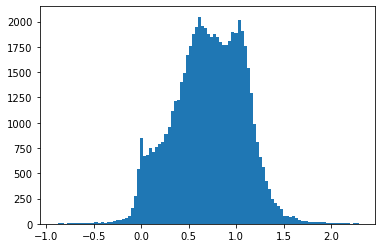

smb_beta


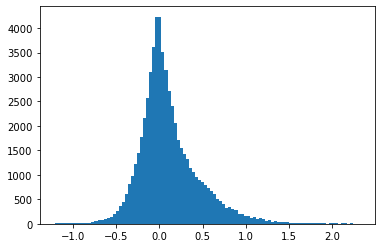

hml_beta


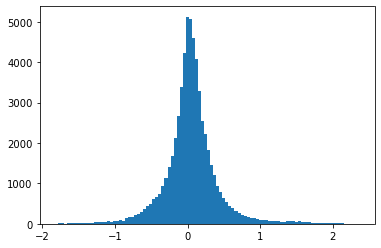

wml_beta


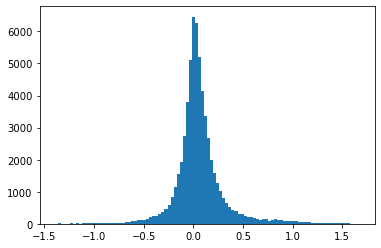

hml_fx_beta


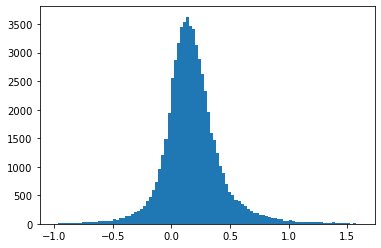

rx_beta


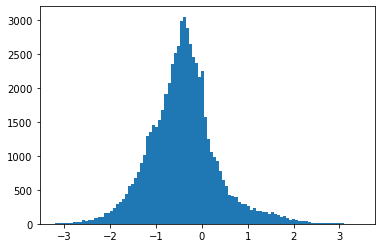

In [20]:
beta_hists(df_betas_lrv11)